# Data Prepartion on DisneyLand Dataset

Whats different?
1. Rather than removing words with more than 15 characters, I removed words that occurred only once in the dataframe. 
2. Added codes for topic modelling.

## Importing the Dataset

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

In [2]:
# Importing the scrape dataset
df = pd.DataFrame(pd.read_csv("merged_reviews.csv"))
df.head()

,review,rating,date
0,This place is definitely the happiest place on...,5 star rating,12/26/2022
1,Disneyland is great for the themes and nostalg...,4 star rating,1/8/2023
2,Price range: ridiculously high To consider: lo...,2 star rating,1/10/2023
3,The Mickey Mouse Salted Pretzel from the Coca ...,1 star rating,1/10/2023
4,"Nicole, Blonde girl, pirates of the Caribbean ...",1 star rating,1/9/2023


## Data Understanding and Preparation

In [3]:
print("Number of records in the dataframe:",df.shape[0])
print("Columns in the dataframe:",list(df.columns))

Number of records in the dataframe: 31800
Columns in the dataframe: ['review', 'rating', 'date']


In [4]:
# Checking for any null values in the dataframe
print("Null values in the dataframe:")
df.isna().sum()

Null values in the dataframe:


review      0
rating      0
date      402
dtype: int64

There are no null values in the review or rating column. 

### Data Preparation - Duplicated Records

In [5]:
df[df.review.duplicated()]

,review,rating,date
4441,"Disney World might be larger, but Disneyland w...",5 star rating,6/19/2016
6134,How far Disneyland has fallen over time!! I gr...,2,Jul 2022
6268,Usually don’t review something as big as Disn...,2,NaN
6984,My autistic son was at Disneyland today and wa...,1,Aug 2019 • Family
7038,I went here for a week with my brother. What a...,5,Jul 2019 • Family
...,...,...,...
29349,I had no expectations of trip to Disneyland be...,5/5,5 years ago on Google
29872,"My family and I are huge Disney fans, but afte...",1/5,6 years ago on Google
31059,We have been having such a hard time this year...,1/5,7 years ago on Google
31273,It's Disneyland! What can I say that you don't...,5/5,6 years ago on Google


From this dataframe, the duplicated texts are quite long and highly unlikely that it was an original review. 

Therefore, I will remove duplicated reviews to reduce the dimension of the dataframe.

Additionally, there are some difference in the format of the rating and date. The format of these data need to be formatted properly for analysis.

In [6]:
print("Percentage of duplicates in the dataframe:",(len(df[df.review.duplicated()])/df.shape[0])*100,"%")

Percentage of duplicates in the dataframe: 0.20440251572327045 %


The total percentage of duplicates in the dataframe contribute only 0.20% of the dataframe. Since there are so little duplicates and dropping the duplicates would barely affect the dataframe's size, I decided that the best approach to handling duplicates would be to drop them

In [7]:
print("Number of records before dropping duplicate:",df.shape[0])
df = df.drop_duplicates(subset='review')
print("Number of records after dropping duplicate:",df.shape[0])

Number of records before dropping duplicate: 31800
Number of records after dropping duplicate: 31735


In [8]:
# Resetting the index of the dataframe after removing duplicates
df = df.reset_index(drop=True)

### Data Understanding - Rating

Extract the given rating from the different rating formats

In [9]:
print(list(df['rating'].unique()))

['5 star rating', '4 star rating', '2 star rating', '1 star rating', '3 star rating', '5', '4', '3', '1', '2', '5/5', '4/5', '3/5', '1/5', '2/5']


In [10]:
# Extract the ratings
def extract_rating(rating_string):
    if "star" in rating_string:
        # Extract the index 0 which will always be the rating.
        return int(rating_string.split(" ")[0])
    else:
        return int(rating_string.split("/")[0])
    
extracted_ratings = [extract_rating(rating) for rating in df['rating']]

In [11]:
df['rating'] = extracted_ratings

In [12]:
df.head()

,review,rating,date
0,This place is definitely the happiest place on...,5,12/26/2022
1,Disneyland is great for the themes and nostalg...,4,1/8/2023
2,Price range: ridiculously high To consider: lo...,2,1/10/2023
3,The Mickey Mouse Salted Pretzel from the Coca ...,1,1/10/2023
4,"Nicole, Blonde girl, pirates of the Caribbean ...",1,1/9/2023


In [13]:
print("Types of rating:",list(df.rating.unique()))

Types of rating: [5, 4, 2, 1, 3]


### Data Preparation - Converting Rating to Sentiment

I assign records with 1 or 2 stars as 'negative', while 4 and 5 stars as 'positive'.

As for texts with a star rating of 3, I assume that the text is neutral; the text may contain either both positive and negative sentiments or none. Since I'm interested in classifying texts into positive or negative classes only so that the business is able to know their customer's sentiment toward their product or service without a grey area (neutral ratings), I will remove records with 3 stars.

In [14]:
# Removing star rating of 3 because it is neutral
df = df[df.rating!=3]

In [15]:
df = df.reset_index(drop=True)

In [16]:
# Machine Learning Models can not work on categorical variables in the form of strings, 
# so we need to change it into numerical form.
df['sentiment'] = df.rating.apply(lambda x: 1 if x >= 4 else 0)
df = df.drop(columns='rating')

In [17]:
df.head()

,review,date,sentiment
0,This place is definitely the happiest place on...,12/26/2022,1
1,Disneyland is great for the themes and nostalg...,1/8/2023,1
2,Price range: ridiculously high To consider: lo...,1/10/2023,0
3,The Mickey Mouse Salted Pretzel from the Coca ...,1/10/2023,0
4,"Nicole, Blonde girl, pirates of the Caribbean ...",1/9/2023,0


Looking at the distribution of classes in the target column:
1 represents positive, 0 represents negative.
Total records: 28947


,occurrences,occurrences (%)
1,24556,84.83%
0,4391,15.17%


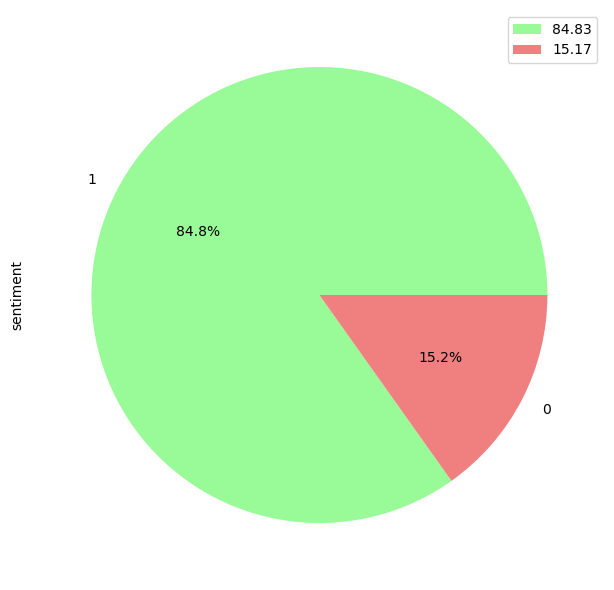

In [18]:
print("Looking at the distribution of classes in the target column:")
print("1 represents positive, 0 represents negative.")

# Checking the distribution of the stars
sentiments = pd.DataFrame({'occurrences': df['sentiment'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df)*100), 2))+"%" for x in df['sentiment'].value_counts()]})
print("Total records:", sum(sentiments['occurrences']))
display(sentiments)

labels = round((df['sentiment'].value_counts()/len(df)*100),2)
sizes = round((df['sentiment'].value_counts()/len(df)*100),2)
color = ['palegreen', 'lightcoral']
(df['sentiment'].value_counts()/len(df)*100).plot(kind='pie', figsize=(14,6), colors=color, autopct = '%1.1f%%')
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

The ratio of positive to negative is quite unbalanced of 85%:15% respectively. The data is heavily unbalanced. Therefore, data balancing is required later.

### Data Understanding - Spread of Reviews across Date

The date column will not be used for sentiment analysis. However, I would like to analyze the trend of reviews over the year.

In [19]:
print("Number of null dates:",df['date'].isna().sum())

Number of null dates: 352


In [20]:
# Since I'm only analyzing the date, I will drop those NA values so that it will not affect the original date spread.
# I will also store it in a secondary dataframe for analysis so that the original records will be maintained.
df_date = pd.DataFrame(df['date'].dropna())

In [21]:
df_date.shape[0]

28595

As identified earlier when looking at the duplicates, the dates are stored in different formats such as:
```
['6/19/2016', 'Jul 2022', 'NaN', 'Aug 2019 • Family', '5 years ago on Google']
```
In order to analyse the trend of reviews, I need to extract their years.

### Performing simple review count trend analysis

In [22]:
# Code to clean the dates
import datetime

def extract_year(date_string):
    if "ago" in str(date_string):
        date_parts = date_string.split(" ")
        now = datetime.datetime.now()
        if "year" in date_parts[1]:
            if 'a' in str(date_parts[0]):
                years_ago = 1
            else:
                years_ago = int(date_parts[0])
            extracted_year = now.year - years_ago
        elif "month" in date_parts[1]:
            if "a" in date_parts[0]:
                months_ago = 1
            else:
                months_ago = int(date_parts[0])
            extracted_year = now.year - (months_ago // 12)
        elif "week" in date_parts[1]:
            if "a" in date_parts[0]:
                weeks_ago = 1
            else:
                weeks_ago = int(date_parts[0])
            extracted_year = now.year - (weeks_ago // 52)
        elif "day" in date_parts[1]:
            extracted_year = now.year
        else:
            extracted_year = date_string
    else:
        # Separate extraction of year
        extracted_year = date_string

    return extracted_year

In [23]:
# Extract the year from dates formatted as "3 years ago on Google" etc.
yearss = [extract_year(date) for date in df_date['date']]

In [24]:
# extracting all years
years = [re.search("20\w\w", str(date)).group() if len(re.findall("20\w\w", str(date)))>0 else 0 for date in yearss]

In [25]:
# Store the cleaned years
df_date['dates'] = years

In [26]:
df_date.dates.unique()

array(['2022', '2023', '2021', '2020', '2019', '2018', '2017', '2016',
       '2015', '2014', '2013', '2011', '2009', '2012', '2010', '2008',
       '2007', '2006'], dtype=object)

In [27]:
# The dates are stored as string as evident in the code above.

# Convert the dates column to integer datatype
df_date.dates = df_date.dates.astype('int')

In [28]:
# I'd like to only analyze the trend over the past decade. Therefore, I only look at years from 2014 onward.
df_date = df_date[df_date.dates>=2014]

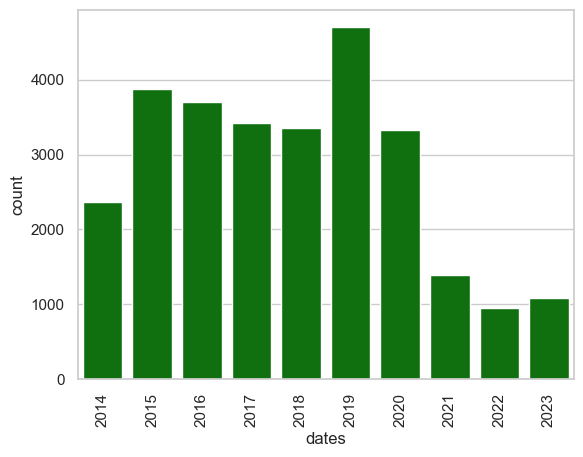

In [29]:
# Trend of reviews over the years from 2006 to 2023.
sns.set_theme(style="whitegrid")
sns.countplot(x=df_date['dates'], color='green')
plt.xticks(rotation=90)
plt.show()

Evidently, the number of ratings dropped due to the Pandemic, reflecting that less people visited DisneyLand after the Pandemimc in 2019. 

However, before the Pandemic, the number of reviews has already started to drop. There are 2 possible reasons for the drop:
1. People are still attending DisneyLand but not writing reviews.
2. People are not attending DisneyLand as frequently as before, thus less reviewers.

Therefore, Disneyland would like to analyse the customer's experience and identify areas of improvement.

### Data Understanding - Checking Word and Word Length Distribution

In [30]:
# Store reviews in a variable
reviews = [review.lower() for review in df['review']]

In [31]:
# Tokenize the words to generate frequency of words.
from nltk.tokenize import word_tokenize
tokenized_words = [word_tokenize(review) for review in reviews]

# Get the word lengths
word_lengths = []

# Get the tokenized words
tokenized_word_list = []

for word_lists in tokenized_words:
    for word in word_lists:
        word_lengths.append(len(word))
        tokenized_word_list.append(word)

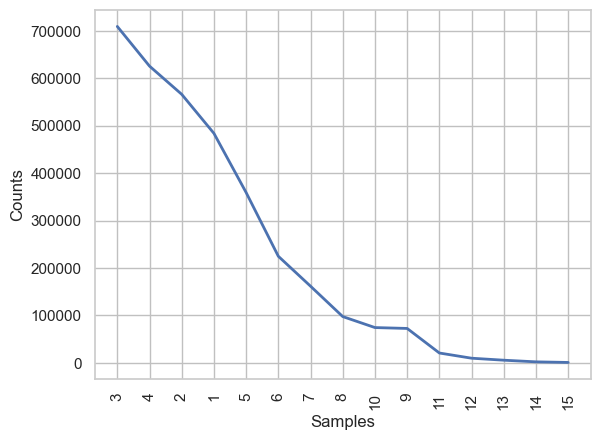

In [32]:
# Generate frequency for all the words
freq_dist = nltk.FreqDist(word_lengths)

# Visualizing 
word_length_frequency_dict = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(word_length_frequency_dict)

# plot the frequency distribution of the top 50 words
freq_dist.plot(15, cumulative=False)
plt.show()

In [33]:
# Look at word lengths of more than 15 where the curve is flat.

odd_lengths = [words for words in tokenized_word_list if len(words)>15]

print("First 10 odd words in the list:",odd_lengths[:10])

First 10 odd words in the list: ['front-of-the-line', 'again.disneyland', 'experiences.spending', 'halloween.luckily', 'not-so-happiest-place', 'hyper-aggressive', 'tp-breaks-off-at-each-square', 'communication/customer', 'experience.recommend', 'restaurants/menus']


Seems like most of the words with lengths above 15 just have punctuations between them. I will add space to separate them.

In [34]:
# Checking for any links that have a domain of .com

links = [words for words in tokenized_word_list if ".com" in words]

print("First 10 words with '.com' in the list:",links[:10])

First 10 words with '.com' in the list: ['youtube.com/c/wackycalif…', 'disneyland.comgetting', 'disney.com', 'me.come', 'disneyland.disney.go.com…to', 'youtube.com/watch', 'youtube.com/watch', 'youtube.com/watch', 'it.coming', 'yelp.com/biz/tiki-juice-…']


Links contain .com and slashes, while words contain more than just '.com' such as '.coming'

In [35]:
# Checking for slashed links

links = [words for words in tokenized_word_list if "//" in words]

print("First 10 links in the list:",links[:10])

First 10 links in the list: ['//', '//', 'note/////', '//www.isitpacked.com/live-crowd-trackers/disneyland/avoid', '//www.citystrollerrentals.com/disneyland-stroller-rentals.html', '//dlrprepschool.com/a-fastpass-guide-for-disneyland-and-california-adventure/', '//www.disneytouristblog.com/', '//disneyland.disney.go.com/guest-services/fastpass/there', '//www.dlandlive.com/closures/', '//www.undercovertourist.com/blog/best-time-visit-disneyland/']


Seems like the odd length words are mostly because the customer did not put spaces inbetween punctuations. This will need to be fixed later.

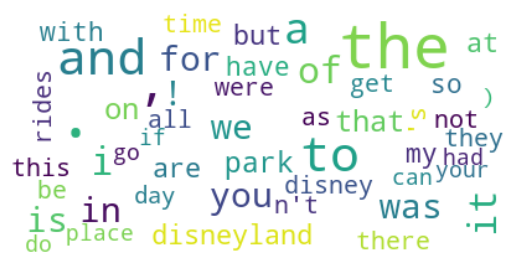

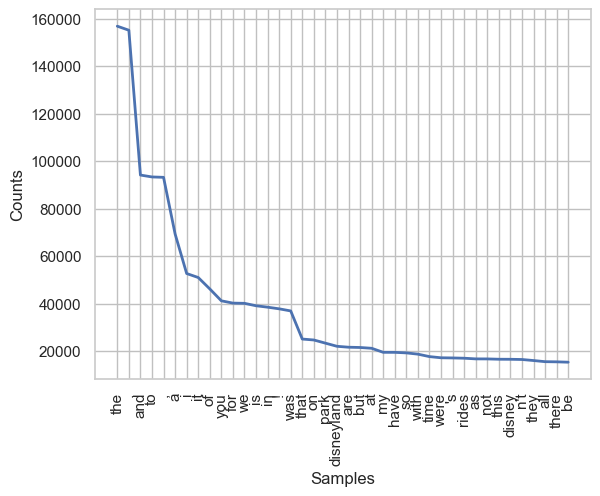

In [36]:
# Generate frequency for all the words
freq_dist = nltk.FreqDist(tokenized_word_list)

# Visualizing 
words = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(words)

# build wordcloud
from wordcloud import WordCloud
wcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate_from_frequencies(freq_dist)

# plot the wordcloud
import matplotlib.pyplot as plt
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# plot the frequency distribution of the top 50 words
freq_dist.plot(40, cumulative=False)
plt.show()

Words that have a large font size occur more frequently in the dataframe.

Based on the word cloud, most of the frequently occuring words are stopwords and punctuations such as 'the' and fullstops.

There are also some common terms related to DisneyLand such as 'park', 'disneyland', 'disney'. These are not useful as many texts contain these terms. Therefore, I will add it to the stopword list for removal later.

## Data Preparation

In [37]:
df.head()

,review,date,sentiment
0,This place is definitely the happiest place on...,12/26/2022,1
1,Disneyland is great for the themes and nostalg...,1/8/2023,1
2,Price range: ridiculously high To consider: lo...,1/10/2023,0
3,The Mickey Mouse Salted Pretzel from the Coca ...,1/10/2023,0
4,"Nicole, Blonde girl, pirates of the Caribbean ...",1/9/2023,0


In [38]:
# date column is not used, therefore remove it to reduce memory usage.
df = df.drop(columns=['date'])
df.head()

,review,sentiment
0,This place is definitely the happiest place on...,1
1,Disneyland is great for the themes and nostalg...,1
2,Price range: ridiculously high To consider: lo...,0
3,The Mickey Mouse Salted Pretzel from the Coca ...,0
4,"Nicole, Blonde girl, pirates of the Caribbean ...",0


### Data Balancing

As identified earlier, the ratio of positive to negative sentiments in the dataframe is quite unbalanced with a ratio of 85:15 respectively. This may cause the model to be biased or overfitted toward the positive sentiments. To tackle this problem, I will balance the model using undersampling.

To prevent a biased and/or overfitted model, I decided to perform undersampling on the majority class, while keeping all the data of the minority class, negative sentiment.

**Approach**:

* I will undersample the majority class, positive sentiment, to contribute 60% of the dataframe.

**Reason**:

* A ratio of 60:40 for positive:negative ensures that the positive class retains majority of its original data and be a representative sample for the positive class.

1 represents positive, 0 represents negative.
Total records: 28947


,occurrences,occurrences (%)
1,24556,84.83%
0,4391,15.17%


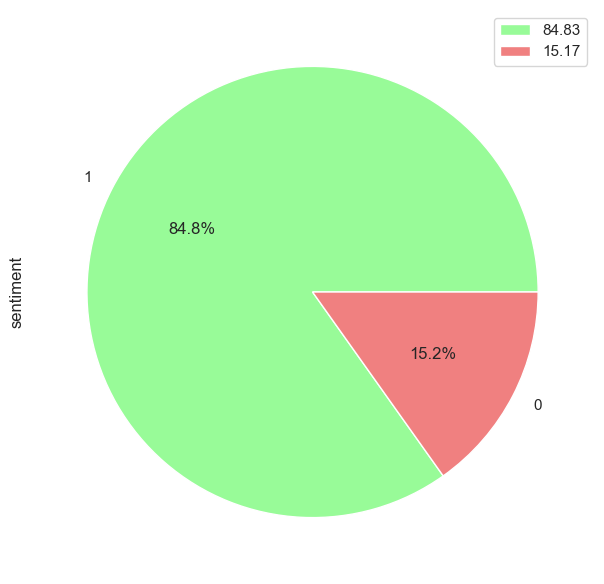

In [39]:
# print("Looking at the distribution of classes in the target column:")
print("1 represents positive, 0 represents negative.")

# Checking the distribution of the stars
sentiments = pd.DataFrame({'occurrences': df['sentiment'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df)*100), 2))+"%" for x in df['sentiment'].value_counts()]})
print("Total records:", sum(sentiments['occurrences']))
display(sentiments)

labels = round((df['sentiment'].value_counts()/len(df)*100),2)
sizes = round((df['sentiment'].value_counts()/len(df)*100),2)
color = ['palegreen', 'lightcoral']
(df['sentiment'].value_counts()/len(df)*100).plot(kind='pie', figsize=(14,6), colors=color, autopct = '%1.1f%%')
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

In [40]:
# required_amt is the amount of samples required to balance positive to negative at a ratio of 60:40.
required_amt = int((len(df[df['sentiment']==0])/40)*60)

df2 = pd.concat([df[df['sentiment']==1].sample(n=required_amt, random_state=42), df[df['sentiment']==0]], axis=0)

# To ensure the same data is sampled and reproduable results, I set a random_state of 42 for the sample function.

In [41]:
df2.head()

,review,sentiment
18158,Everyone said that the days after Christmas ar...,1
14892,Went here in 2010 it was great but much better...,1
9688,As any good amusement park has: it is crowded....,1
4903,"Love, Love, Love this place! Came here since ...",1
21989,"It's Disneyland. Somewhere that, if finances a...",1


In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10977 entries, 18158 to 28934
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10977 non-null  object
 1   sentiment  10977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 257.3+ KB


The index of the dataframe is weird after sampling.

In [43]:
# Reset the index
df2 = df2.reset_index(drop=True)

In [44]:
# Checking the distribution of the stars in the new dataframe
sentiments = pd.DataFrame({'occurrences': df2['sentiment'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df2)*100), 2))+"%" for x in df2['sentiment'].value_counts()]})
print("Total records:", sum(sentiments['occurrences']))
display(sentiments)

Total records: 10977


,occurrences,occurrences (%)
1,6586,60.0%
0,4391,40.0%


In [45]:
# Detect any foreign language and remove it to reduce noise in the data and prevent it from 
# affecting the sentiment classification
from langdetect import detect
foreign_index = [index for index in df2.index if detect(df2['review'][index]) != 'en']

In [46]:
for indexes in foreign_index:
    print(indexes,":",df2['review'][indexes])

652 : Recommend bring water and umbrella.and enjoy with your family aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
1307 : Fun rides, parade. Expensive food
1440 : Best place i have ever been to
1766 : Such a magical experience.
1841 : Excellent  Cal Disney ride. Everyone must experience
3085 : My kids loved it as did i.
3622 : So much fun
3631 : Amazing! Duh.
4879 : Very nice
5286 : Always a good time
5513 : GREAT FAMILY PARK....BUT....YOU BETTER PLAN ON SPENDING ($200.00) PER FAMILY MEMBER PER DAY....(MOM + DAD & 3 KIDS = $1000.00 PER DAY) IF YOU WANNA SEE ALL OF THE PARK....YOU'LL NEED (2 DAYS) GUARANTEED ($2,000.00 FOR A FAMILY OF 5 GETS YOU : 1)PARK ENTRY FEE 2)PARKING FEE 3)MEALS 4)LODGING....BOTTOM LINE IS....BRING LOTS OF MONEY!!!
5922 : My favorite place!
10050 : Genius plus, more like genie minus


These texts do not seem to be foreign languages. Therefore, I will leave them as it is.

# Data Preparation - For Sentiment Classification 

### Extract POS Tag

Research has shown the presence of adjectives and adverbs is usually a good indicator of text subjectivity. In other words, statements that use adjectives like “interesting,” “problematic” and “awesome” might be more likely to convey a subjective point of view than statements that do not include those adjectives.

Adjectives and adverbs typically convey sentiment in a sentence, so they can be useful in sentiment analysis. However, including all POS tag words can provide additional information, such as the subject and verb, which can also contribute to the sentiment.

Thus, I will not use the adjectives and adverbs only as feature sets for sentiment classification, but all the words in the text.

In [47]:
from nltk.tokenize import sent_tokenize
def tagPOS(text):
    tokenized = sent_tokenize(text) 
    tagged_text = []

    for i in tokenized:
        # Word tokenizers is used to find the words 
        wordsList = nltk.word_tokenize(i) 

        #  Using a Tagger. Which is part-of-speech tagger or POS-tagger.  
        tagged = nltk.pos_tag(wordsList) 
        tagged_text.extend(tagged)

    return tagged_text

df2['POS_review'] = df2['review'].apply(lambda x: tagPOS(x))

In [48]:
def extract_pos(x):
    # Extracting words that have an adjectives (JJ) or adverb (RB) tag
    extracted_words = [word for (word,tag) in x if tag.startswith("JJ") or tag.startswith("RB")]
    return extracted_words
        
df2['adj_adv'] = df2['POS_review'].apply(lambda x: extract_pos(x))
df2.head()

,review,sentiment,POS_review,adj_adv
0,Everyone said that the days after Christmas ar...,1,"[(Everyone, NN), (said, VBD), (that, IN), (the...","[busiest, first, so, overwhelmed, insane, upco..."
1,Went here in 2010 it was great but much better...,1,"[(Went, NN), (here, RB), (in, IN), (2010, CD),...","[here, great, much, better, more]"
2,As any good amusement park has: it is crowded....,1,"[(As, IN), (any, DT), (good, JJ), (amusement, ...","[good, disneyland, bread, most, bang, other, r..."
3,"Love, Love, Love this place! Came here since ...",1,"[(Love, NNP), (,, ,), (Love, NNP), (,, ,), (Lo...","[here, little, dad, annual, so, many, always, ..."
4,"It's Disneyland. Somewhere that, if finances a...",1,"[(It, PRP), ('s, VBZ), (Disneyland, NNP), (., ...","[Somewhere, somewhere, least, once, true, terr..."


In [49]:
# Identifying texts with no adjectives or adverbs
empty_indexes = [i for i in df2.index if len(df2['adj_adv'][i]) == 0]
print("Number of texts with no adjectives or adverbs inside:",len(empty_indexes))

Number of texts with no adjectives or adverbs inside: 75


Due to no adjectives or adverbs identified, it would make the sentiment analysis classification tougher. Therefore, I will remove it to prevent it from affecting the model's accuracy in classification.

In [50]:
# Removing those with no adjective/adverbs
df2 = df2.drop(index=empty_indexes)
# Resetting the index
df2 = df2.reset_index(drop=True)

## Data Understanding - Sentiment Top Words

In [51]:
negative_words = []
positive_words = []

for index in df2.index:
    words = df2['adj_adv'][index]
    if df2['sentiment'][index] == 0:
        negative_words.extend(words)
    else:
        positive_words.extend(words)

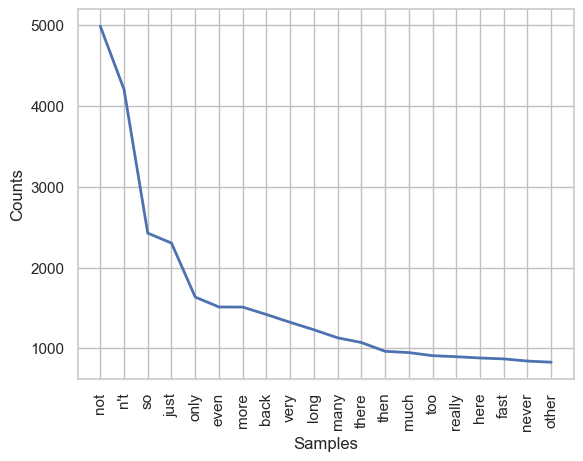

In [52]:
# Generate frequency for the top negative words
freq_dist = nltk.FreqDist(negative_words)

# Visualizing 
words = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(words)

# Generate line chart to show the top words
# plot the frequency distribution of the top 50 words
freq_dist.plot(20, cumulative=False)
plt.show()

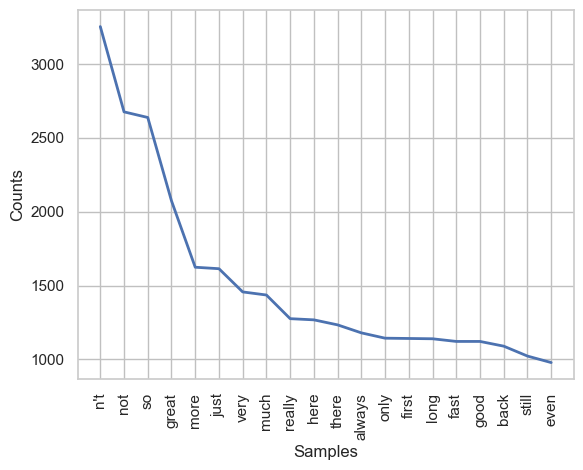

In [53]:
# Generate frequency for the top positive words
freq_dist = nltk.FreqDist(positive_words)

# Visualizing 
words = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(words)

# plot the frequency distribution of the top 50 words
freq_dist.plot(20, cumulative=False)
plt.show()

Based on the top adjective/adverb words found in both sentiments, both share almost the same top 15 words. Therefore, I will add some of the top words to the stopword list for removal:

'n't', 'not', 'so', 'just', 'only', 'back', 'more'.

Removing these common words reduces the overlapping common words among the two sentiments and allows the model to weigh the more important words and classify the texts more distinctively.

## Removing Pattern Words

These pattern words include double-slashed and links. These words do not provide any detail toward the text's sentiment and are considered noise which may cause the model to perform poorly with the presence of these words. Therefore, I will remove them through pattern matching.

Additionally, the negator words such as "don't" are converted to "dont" so that they will not be removed from the stopword list which contains negator words that have apostrophe only e.g., "don't".

Lastly, removing numbers, punctuations, and new line codes found previously when displaying the head of the dataframe.

In [54]:
# Store reviews in a variable
reviews = [review.lower() for review in df2['review']]

In [55]:
print("Number of records in the dataframe:", df2.shape[0])

Number of records in the dataframe: 10902


In [56]:
import re

# Removing // words.
doubleslashed_pattern = '[^\s]*(//)+[^\s]*'

# Removing links
link_pattern = '[^\s]*(\.)+[^\s]*(\/)+[^\s]*'

# Keeping negator words
negator_pattern = '\''

# Removing remaining punctuations/numbers
remaining_pattern = '[^a-zA-Z\s]+'

for ind in df2.index:
    reviews[ind] = re.sub(doubleslashed_pattern, '', reviews[ind])
    reviews[ind] = re.sub(link_pattern, ' ', reviews[ind])
    reviews[ind] = re.sub(negator_pattern, '', reviews[ind])
    reviews[ind] = re.sub(remaining_pattern, ' ', reviews[ind])

In [57]:
df2['sentiment_cleaned_review'] = reviews

In [58]:
# Removing stopwords, punctuations, and words of length below 2.
import string
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['park', 'disneyland', 'disney', "n't", 'not', 'so', 'just', 'only', 'back', 'more'])
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def clean(texts):
    cleaned_words = []
    for word in texts:
        # Remove stopwords and numbers
        if word not in stopwords and not word.isdigit() and len(words)>2:
            
            # Removing punctuations
            punc_free = ''.join([ch for ch in word if ch not in string.punctuation])
            
            # Removing words that have lengths less than 2 as words less than 2 usually provide little to no insights due to low meaning
            if len(punc_free)>2 and not word.isdigit():
                
                # Stemming the words.
                cleaned_words.append(porter_stemmer.stem(punc_free))
                # Stemming is used to reduce the dimensionality of words in the dataframe.
                # Since I'm doing sentiment analysis based on occurrence of words in the text, context won't be necessary as order of words are not captured within the bag of words.
                # Therefore, stemming is used over lemmatization to improve computational performance.

    return cleaned_words

# Create Feature Set
df2['review_tokens'] = df2['sentiment_cleaned_review'].apply(lambda x: word_tokenize(x.lower()))
df2['review_tokens'] = df2['review_tokens'].apply(lambda x: clean(x))  
df2.head()

,review,sentiment,POS_review,adj_adv,sentiment_cleaned_review,review_tokens
0,Everyone said that the days after Christmas ar...,1,"[(Everyone, NN), (said, VBD), (that, IN), (the...","[busiest, first, so, overwhelmed, insane, upco...",everyone said that the days after christmas ar...,"[everyon, said, dai, christma, busiest, year, ..."
1,Went here in 2010 it was great but much better...,1,"[(Went, NN), (here, RB), (in, IN), (2010, CD),...","[here, great, much, better, more]",went here in it was great but much better if...,"[went, great, much, better, kid, gone, famili,..."
2,As any good amusement park has: it is crowded....,1,"[(As, IN), (any, DT), (good, JJ), (amusement, ...","[good, disneyland, bread, most, bang, other, r...",as any good amusement park has it is crowded ...,"[good, amus, crowd, your, look, food, within, ..."
3,"Love, Love, Love this place! Came here since ...",1,"[(Love, NNP), (,, ,), (Love, NNP), (,, ,), (Lo...","[here, little, dad, annual, so, many, always, ...",love love love this place came here since ...,"[love, love, love, place, came, sinc, littl, d..."
4,"It's Disneyland. Somewhere that, if finances a...",1,"[(It, PRP), ('s, VBZ), (Disneyland, NNP), (., ...","[Somewhere, somewhere, least, once, true, terr...",its disneyland somewhere that if finances af...,"[somewher, financ, afford, freedom, somewher, ..."


In [59]:
df2 = df2.drop(columns=['POS_review', 'adj_adv'])

In [60]:
# Store all tokens
tokens = [tokens for entry in df2.review_tokens for tokens in entry]

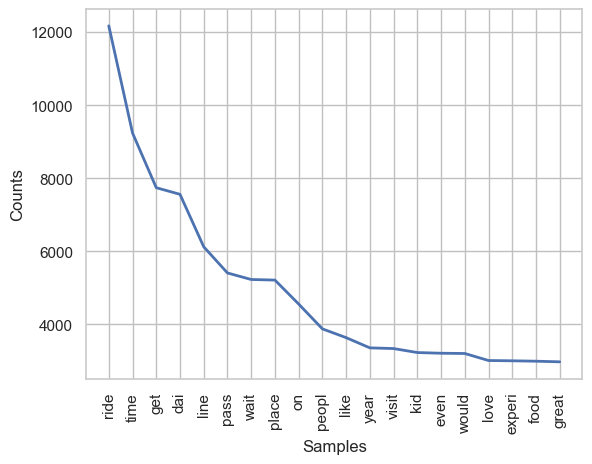

In [61]:
# Generate frequency for all the words
freq_dist = nltk.FreqDist(tokens)

# Visualizing 
word_length_frequency_dict = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(word_length_frequency_dict)

# plot the frequency distribution of the top 50 words
freq_dist.plot(20, cumulative=False)
plt.show()

In [62]:
# Looking at words that are quite long
odd_lengths = [words for words in tokens if len(words)>15]
print(odd_lengths[:15])

['makeoverguardian', 'halloweentimeindisnei', 'disneylandorigin', 'supercalifragilisticexpialidic', 'accuratefirework', 'ggfffhhhhggggghhhhh', 'wednesdayjanuari', 'yourecmissingvout', 'resistancesmuggl', 'mansionincredicoasterindiana', 'cruisematterhorn', 'toursmatterhornspac', 'originallydisneyland', 'awesomehyperspac', 'disneylandanaheimstil']


Seems like the rest of the odd length words are either naturally long words, combined words, or excess characters.

In [63]:
# Checking for words that occur once in the corpus
one_occurrence = []
for key in word_length_frequency_dict:
    if word_length_frequency_dict[key] == 1:
        one_occurrence.append(key)

In [64]:
len(one_occurrence)

5589

There are a total of 5605 words that occur once only in the corpus. These words provide little insight into what the text's sentiment is since it occurs once only. Therefore, I will remove these 5605 words to reduce the noise in the dataset.

There are some frequently occuring words that carry little meaning or context toward the sentiment of the text such as 'get', 'would', 'on'.

In [65]:
# Second round of cleaning, removing additional stopwords.
import string
stopwords.extend(['get', 'on', 'would'])
stopwords.extend(one_occurrence)
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def clean(texts):
    cleaned_words = []
    for word in texts:
        # Remove stopwords and numbers
        if word not in stopwords and not word.isdigit() and len(word)>2:
            
            # Removing punctuations
            punc_free = ''.join([ch for ch in word if ch not in string.punctuation])
            
            # Removing words that have lengths less than 2 as words less than 2 usually provide little to no insights due to low meaning
            if len(punc_free)>2 and not punc_free.isdigit():
                
                # Stemming the words.
                cleaned_words.append(porter_stemmer.stem(punc_free))
                # Stemming is used to reduce the dimensionality of words in the dataframe.
                # Since I'm doing sentiment analysis based on occurrence of words in the text, context won't be necessary as order of words are not captured within the bag of words.
                # Therefore, stemming is used over lemmatization to improve computational performance.

    return cleaned_words

# Create Feature Set
df2['review_tokens'] = df2['review'].apply(lambda x: word_tokenize(x.lower()))
df2['review_tokens'] = df2['review_tokens'].apply(lambda x: clean(x))  
df2.head()

,review,sentiment,sentiment_cleaned_review,review_tokens
0,Everyone said that the days after Christmas ar...,1,everyone said that the days after christmas ar...,"[everyon, said, dai, christma, busiest, year, ..."
1,Went here in 2010 it was great but much better...,1,went here in it was great but much better if...,"[went, great, much, better, kid, gone, famili,..."
2,As any good amusement park has: it is crowded....,1,as any good amusement park has it is crowded ...,"[good, amus, crowd, look, food, within, recomm..."
3,"Love, Love, Love this place! Came here since ...",1,love love love this place came here since ...,"[love, love, love, place, came, sinc, littl, d..."
4,"It's Disneyland. Somewhere that, if finances a...",1,its disneyland somewhere that if finances af...,"[somewher, financ, afford, freedom, somewher, ..."


In [66]:
# Store all tokens
tokens = [tokens for entry in df2.review_tokens for tokens in entry]

In [67]:
# Checking if there are words above the length of 15
odd_lengths = [words for words in tokens if len(words)>14]
print(odd_lengths[:15])

['rocketpeoplemov', 'destinationwalt', 'otherdisneyland', 'sundowndisneyland', 'fantasylandfind', 'makeoverguardian', 'experiencefootnot', 'everyoneregardless', 'magicdisneyland', 'attractionsshow', 'halloweentimeindisnei', 'awesomealthough', 'smallerdisneyland', 'restauranteateri', 'partymatterhornindiana']


Although there are still words above the length of 15, these words appear at least twice within the corpus. Therefore, they provide some help in the model's classification.

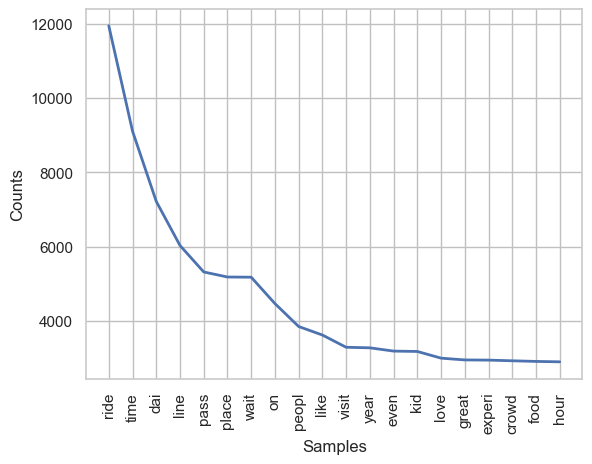

In [68]:
# Generate frequency for all the words
freq_dist = nltk.FreqDist(tokens)

# Visualizing 
word_length_frequency_dict = dict([(k,v) for k,v in freq_dist.items()])

# create frequency distribution of the filtered words
freq_dist = nltk.FreqDist(word_length_frequency_dict)

# plot the frequency distribution of the top 50 words
freq_dist.plot(20, cumulative=False)
plt.show()

In [69]:
# print("Looking at the distribution of classes in the target column:")
print("1 represents positive, 0 represents negative.")

# Checking the distribution of the stars
sentiments = pd.DataFrame({'occurrences': df2['sentiment'].value_counts(),
                      'occurrences (%)': [str(round((x/len(df2)*100), 2))+"%" for x in df2['sentiment'].value_counts()]})
print("Total records:", sum(sentiments['occurrences']))
display(sentiments)

1 represents positive, 0 represents negative.
Total records: 10902


,occurrences,occurrences (%)
1,6527,59.87%
0,4375,40.13%


Majority of the top occuring words are now relevant to the topic such as 'ride', 'time', 'line', etc. These words provide more information and may help improve the classification of the sentiment analysis models.

The ratio of positive class (1) to negative class (0) is also balanced of 60:40 respectively.

In [70]:
df2.head()

,review,sentiment,sentiment_cleaned_review,review_tokens
0,Everyone said that the days after Christmas ar...,1,everyone said that the days after christmas ar...,"[everyon, said, dai, christma, busiest, year, ..."
1,Went here in 2010 it was great but much better...,1,went here in it was great but much better if...,"[went, great, much, better, kid, gone, famili,..."
2,As any good amusement park has: it is crowded....,1,as any good amusement park has it is crowded ...,"[good, amus, crowd, look, food, within, recomm..."
3,"Love, Love, Love this place! Came here since ...",1,love love love this place came here since ...,"[love, love, love, place, came, sinc, littl, d..."
4,"It's Disneyland. Somewhere that, if finances a...",1,its disneyland somewhere that if finances af...,"[somewher, financ, afford, freedom, somewher, ..."


In [71]:
df2[['sentiment', 'review_tokens']].to_csv("sentiment_classification_reviews.csv", index=False, encoding='utf-8')

# Data Preparation - For Topic Modelling

Only the texts are required for topic modelling. I will be using the df2 dataframe, which is the balanced dataframe. 

Balancing the target class in topic modeling is not required. However, it can be beneficial depending on the data and the objective of the model. If the target class is imbalanced, the topics might be mostly about positive or negative aspects only. Therefore, I will use the balanced dataframe, df2.

In [72]:
# Store reviews in a variable
reviews = [review.lower() for review in df2['review']]

In [73]:
import re

# Removing // words.
doubleslashed_pattern = '[^\s]*(//)+[^\s]*'

# Removing links
link_pattern = '[^\s]*(\.)+[^\s]*(\/)+[^\s]*'

# Removing remaining punctuations/numbers
remaining_pattern = '[^a-zA-Z\s]+'

for ind in df2.index:
    reviews[ind] = re.sub(doubleslashed_pattern, '', reviews[ind])
    reviews[ind] = re.sub(link_pattern, ' ', reviews[ind])
    reviews[ind] = re.sub(remaining_pattern, ' ', reviews[ind])

In [74]:
doc_clean = [review.split() for review in reviews]

In [75]:
for index in range(len(doc_clean)):
    clean_words = []
    for word in doc_clean[index]:
        # Removing stopwords, numbers, and words with length of below 2. These inputs provide little to no value for topic modelling
        if word not in stopwords and not word.isdigit() and len(word)>2:
            punc_free = ''.join([ch for ch in word if ch not in string.punctuation])
            # Ensure length of word is still above 2 after removing punctuation in words
            if len(punc_free)>2 and not punc_free.isdigit():
                clean_words.append(punc_free)
    doc_clean[index] = clean_words

Other data pre-processing steps such as lemmatizing and common word removal will be performed in the modelling notebook. This allows for flexible change of data processing steps.

In [76]:
# Store the cleaned text in a dataframe. 
# Sentiment is not required for topic modelling.
topic_clean_reviews = pd.DataFrame({"reviews":doc_clean})

In [77]:
topic_clean_reviews.head()

,reviews
0,"[everyone, said, days, christmas, busiest, yea..."
1,"[went, great, much, better, kids, gone, famili..."
2,"[good, amusement, crowded, looking, food, with..."
3,"[love, love, love, place, came, since, little,..."
4,"[somewhere, finances, afford, freedom, somewhe..."


In [78]:
# Export the data
topic_clean_reviews.to_csv("topic_modelling_reviews.csv", index=False, encoding='utf-8')